In [1]:
import numpy as np
from scipy.linalg import sqrtm
import scipy as sc
import qiskit
import random
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm

# Definition of the quantum gates

In [2]:
X=np.array([[0,1],[1,0]])
Y=np.array([[0,-1j],[1j,0]])
Z=np.array([[1,0],[0,-1]])
sigma=np.array([np.eye(2,dtype="complex"),X,Y,Z])
I=np.eye(2,dtype="complex")
H=np.array([[1,1],[1,-1]])/np.sqrt(2)
CNOT_ideal=np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])

# Numpy transformations

In [3]:
def get_psi(n_qubits): #Random state Haar measure
    psi = np.reshape(np.array([np.random.normal() for i in range(2**n_qubits)]) + 1j*np.array([np.random.normal() for i in range(2**n_qubits)]), (2**n_qubits,1))
    psi=psi/(np.sqrt(psi.conjugate().T@psi))
    psi=psi/np.exp(1j*np.angle(psi[0][0]))
    return psi
def equal(a,b):
    return np.linalg.norm(a-b)<0.000001 #проверка равентства матриц
def is_unitary(matrix):
    if(np.linalg.norm(np.eye(int(np.sqrt(matrix.size)))-matrix.dot(matrix.transpose().conjugate()))<0.00001):
        return True
    return np.linalg.norm(np.eye(int(np.sqrt(matrix.size)))-matrix.dot(matrix.transpose().conjugate()))
def is_hermit(matrix): #return True if matrix is hermitian
    return np.linalg.norm(matrix.T.conjugate()-matrix)<0.0000001
def trace(a):
    return np.trace(a)/len(a)
def convert_base(value, base,n_qubits, length=16):# меняет систему исчесления
    if value < 0:
        value = ( 1<<length ) + value
 
    res = ''
    while value > 0:
        res = str(value % base) + res
        value //= base
    while len(res)<n_qubits:
        res="0"+res
    return res
def decompose(A,n_qubits): # разложение на строчки Паули
    parameters=np.array([])
    for i in range(4**n_qubits):
        a=sigma[int(convert_base(i,4,n_qubits=n_qubits)[0])]
        for j in range(1,n_qubits):
            a=np.kron(a,sigma[int(convert_base(i,4,n_qubits=n_qubits)[j])])
        parameters=np.append(parameters,trace(A@a))
    return parameters
def compose(parameters,n_qubits): # сборка по параметрам разложения
    A=np.zeros((2**n_qubits,2**n_qubits),dtype="complex")
    for i in range(4**n_qubits):
        a=sigma[int(convert_base(i,4,n_qubits=n_qubits)[0])]
        for j in range(1,n_qubits):
            a=np.kron(a,sigma[int(convert_base(i,4,n_qubits=n_qubits)[j])])
        A=A+parameters[i]*a
    return A
def Pauli_system(a): #Auxiliary function for Pauli strings decomposition
    Pauli_string=''
    for i in range(len(a)):
        if a[i]=='0':
            Pauli_string+="I"
        if a[i]=="1":
            Pauli_string+="X"
        if a[i]=="2":
            Pauli_string+="Y"
        if a[i]=="3":
            Pauli_string+="Z"
    return Pauli_string 
def write_decomposition(parameters,n_qubits): #write decomposition to Pauli strings and return non-zero strings
    a=""
    b=""
    for i in range(len(parameters)):
        if np.abs(parameters[i])>0.00001:
            if np.imag(parameters[i])==0:
                if np.real(parameters[i])>0:
                    print("+ "+str(np.real(parameters[i]))+" "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ")
                else:
                    print("- "+str(-np.real(parameters[i]))+" "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ")
            elif np.real(parameters[i])==0:
                if np.imag(parameters[i])>0:
                    print("+ "+str(np.imag(parameters[i]))+"i "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ")
                else:
                    print("- "+str(-np.imag(parameters[i]))+"i "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ") 
            else:
                if np.imag(parameters[i])>0 and np.real(parameters[i])>0:
                    print("+ ("+str(np.real(parameters[i]))+"+ "+str(np.imag(parameters[i]))+"i) "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ")
                elif np.imag(parameters[i])<0 and np.real(parameters[i])>0:
                    print("+ ("+str(np.real(parameters[i]))+"- "+str(-np.imag(parameters[i]))+"i) "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ")
                elif np.imag(parameters[i])>0 and np.real(parameters[i])<0:
                    print("+ (-"+str(np.real(parameters[i]))+"+ "+str(-np.imag(parameters[i]))+"i) "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ")
                else:
                    print("- ("+str(np.real(parameters[i]))+"+ "+str(-np.imag(parameters[i]))+"i) "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ")
            b+=Pauli_system(convert_base(i,4,n_qubits=n_qubits))+";"
    return b.split(";")[:-1:]
def Unitaries(decomposition,n_qubits): #return matrices in decomposition (first use decompose function)
    Unit=np.eye(2**n_qubits,dtype="complex")
    for i in range(1,len(decomposition)):
        if decomposition[i]!=0:
            a=sigma[int(convert_base(i,4)[0])]
            for j in range(1,n_qubits):
                a=np.kron(a,sigma[int(convert_base(i,4)[j])])
            Unit=np.append(Unit,a,axis=0)
    return np.reshape(Unit,(len(decomposition[decomposition!=0]),2**n_qubits,2**n_qubits))
def h_decompose(matrix): #decompose a matrix to sum of the 2 hermitian operators
    H1=0.5*(matrix+matrix.T.conjugate())
    H2=-0.5j*(matrix-matrix.T.conjugate())
    if is_hermit(H1) and is_hermit(H2):
        return H1,H2
    else:
        return False
def u_decompose(A): #decompose a hermitian matrix to sum of 2 unitaries
    U1=A+1j*sqrtm(np.eye(len(A))-A@A)
    U2=A-1j*sqrtm(np.eye(len(A))-A@A) 
    if is_unitary(U1) and is_unitary(U2):
        return U1,U2
    else:
        return False
def Rx(theta):
    return np.array([[np.cos(theta/2),-1j*np.sin(theta/2)],[-1j*np.sin(theta/2),np.cos(theta/2)]])
def Ry(theta):
    return np.array([[np.cos(theta/2),-np.sin(theta/2)],[np.sin(theta/2),np.cos(theta/2)]])
def QFT(n):
    w=np.exp(2j*np.pi/(2**n))
    gate=np.zeros((2**n,2**n),dtype="complex")
    for i in range(2**n):
        for j in range(2**n):
            gate[i][j]=w**(i*j)
    return gate/np.sqrt(2**n)
def L(n):
    matrix=np.zeros((2**n,2**n),dtype="complex")
    for i in range(2**n):
        matrix[i][i-1]=1
    return matrix
def U3gate(x,y,z):
    return np.array([[np.cos(x/2),(-1)*np.exp(1j*z)*np.sin(x/2)],[np.exp(1j*y)*np.sin(x/2),np.exp(1j*(y+z))*np.cos(x/2)]])
def CU3gate(x,y,z):
    return np.array([[1,0,0,0],[0,1,0,0],[0,0,np.cos(x/2),-np.exp(1j*z)*np.sin(x/2)],[0,0,np.exp(1j*y)*np.sin(x/2),np.exp(1j*(y+z))*np.cos(x/2)]])
def two_qubit_state(state):
    if np.imag(state[0][0])>0.00000001:
        print("invalid state")
        return 0
    x1=2*np.arccos(np.sqrt(np.abs(state[0][0])**2+np.abs(state[1][0])**2))
    x2=np.angle(state[2][0])
    y1=2*np.arctan(np.abs((state[1][0]))/(np.abs(state[0][0])))
    y2=np.angle(state[1][0])
    z1=2*np.arccos(np.abs(state[2][0])/np.sqrt(1-np.abs(state[0][0])**2-np.abs(state[1][0])**2))-y1
    z2=np.angle(state[3][0])-np.angle(state[2][0])
    return CU3gate(z1,z2,-y2)@np.kron(U3gate(x1,x2,0),U3gate(y1,y2,0))
def QFT(n):
    w=np.exp(2j*np.pi/(2**n))
    gate=np.zeros((2**n,2**n),dtype="complex")
    for i in range(2**n):
        for j in range(2**n):
            gate[i][j]=w**(i*j)
    return gate/np.sqrt(2**n)
def rho_fidelity(a,b):
    fidelity=(np.trace(sqrtm(sqrtm(a)@b@sqrtm(a))))**2
    if np.abs(np.imag(fidelity))>0.0000001:
        print("error")
        return 0
    return np.real(fidelity)
def pure_quantum_states_fidelity(a,b):
    return (np.abs(a.T.conjugate()@b)**2)[0][0]


# Creation matrix A

In [4]:
def create_A(c,n_qubits):
    A=np.zeros((2**n_qubits,2**n_qubits),dtype=complex)
    for i in range(2**n_qubits):
        if i!=(2**n_qubits-1):
            A[i][i+1]=1
        if i!=0:
            A[i][i-1]=1
        A[i][i]=-2-c
    A[0][-1]=1
    A[-1][0]=1
    return A

In [5]:
x_substituted_b_fidelity=np.array([])
x_substituted_x_fidelity=np.array([])
c=10
for n_qubits in tqdm(range(2,15)):
    A_new_F_shift_c0_diag=np.array([-4*(np.pi*i/2**n_qubits-np.pi/2)**2 for i in range(2**n_qubits)])
    A_new_F_c0=np.roll(A_new_F_shift_c0_diag,2**(n_qubits-1))
    A_new_F=np.diag(A_new_F_c0-c)
    A_new=QFT(n_qubits).T.conjugate()@A_new_F@QFT(n_qubits)
    A_new_inv=np.linalg.inv(A_new)
    A_inv=np.linalg.inv(create_A(c,n_qubits))
    x_substituted_b_fidelity_mean=np.array([])
    x_substituted_x_fidelity_mean=np.array([])
    for initial in range(1000):
        b=get_psi(n_qubits)
        x_substituted_spectrum=A_new_inv@b
        x_substituted_spectrum/=np.sqrt(x_substituted_spectrum.T.conjugate()@x_substituted_spectrum)
        x=A_inv@b
        x/=np.sqrt(x.T.conjugate()@x)
        x_substituted_b_fidelity_mean=np.append(x_substituted_b_fidelity_mean,pure_quantum_states_fidelity(b,x_substituted_spectrum))
        x_substituted_x_fidelity_mean=np.append(x_substituted_x_fidelity_mean,pure_quantum_states_fidelity(x,x_substituted_spectrum))
    x_substituted_b_fidelity=np.append(x_substituted_b_fidelity,x_substituted_b_fidelity_mean.mean())
    x_substituted_x_fidelity=np.append(x_substituted_x_fidelity,x_substituted_x_fidelity_mean.mean())
    print(n_qubits,x_substituted_b_fidelity_mean.mean(),x_substituted_x_fidelity_mean.mean())

 15%|████████████▊                                                                      | 2/13 [00:00<00:01,  8.13it/s]

2 0.957686135716181 0.9883614974047537
3 0.9620329039303412 0.9917474590931553


 23%|███████████████████▏                                                               | 3/13 [00:00<00:01,  5.75it/s]

4 0.9617705058234935 0.9925065568473241


 31%|█████████████████████████▌                                                         | 4/13 [00:00<00:02,  3.96it/s]

5 0.9617508816299711 0.9927893851497468


 38%|███████████████████████████████▉                                                   | 5/13 [00:01<00:03,  2.61it/s]

6 0.9608591748123652 0.9926281526608235


 46%|██████████████████████████████████████▎                                            | 6/13 [00:03<00:05,  1.24it/s]

7 0.9607845395432874 0.9926501231479694


 54%|████████████████████████████████████████████▋                                      | 7/13 [00:06<00:09,  1.58s/it]

8 0.9605783571566573 0.9926134012768066


 62%|███████████████████████████████████████████████████                                | 8/13 [00:13<00:16,  3.34s/it]

9 0.9604682968679763 0.9926034723130917


 62%|███████████████████████████████████████████████████                                | 8/13 [00:27<00:17,  3.46s/it]


KeyboardInterrupt: 

In [ ]:
# with open('100error_scaling.txt', 'w', encoding='utf-8') as f:
#     for samples in x_substituted_b_fidelity:
#         f.write(str(samples)+"\t")
# with open('susbtitution_scaling_analysys.txt', 'w', encoding='utf-8') as f:
#     for samples in x_substituted_x_fidelity:
#         f.write(str(samples)+"\t")        

In [6]:
plt.plot(x_substituted_b_fidelity)

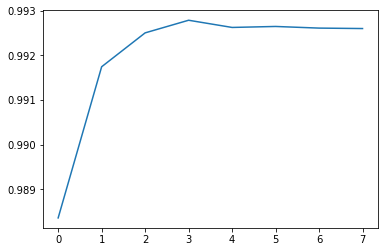

In [7]:
plt.plot(x_substituted_x_fidelity)

In [ ]:
 x_substituted_b_fidelity_mean

In [ ]:
x_substituted_spectrum

In [ ]:
b